In [1]:
import utils
import augment
import numpy as np
from model_03 import get_model
import losses
from keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler, ProgbarLogger
from keras import backend as K
from keras import optimizers
from datetime import datetime
import matplotlib.pyplot as plt
import os
import metrics

Using TensorFlow backend.


In [2]:
img_size = 256
n_kernels = 2
d_train = "./data/{}/train/".format(img_size)
d_test = "./data/{}/test".format(img_size)
files = utils.get_files(d_train, verbose=False)
n_valid = int(len(files) * 0.15)
files_valid = files[:n_valid]
files_train = files[n_valid:]
d = datetime.now().strftime("%m_%d_%Y_%H_%M_%S")
f_model = "model_{}.h5".format(d)

In [6]:
files_train = files_train[:10]
files_valid = files_valid[:5]
X_train, Y_train = utils.load_data(files_train)
X_valid, Y_valid = utils.load_data(files_valid) 

Loading data...
samples     10
Img size  ( 256, 256)
size      0.01 GB
Loading data...
samples      5
Img size  ( 256, 256)
size      0.01 GB


In [7]:
n_ones = np.sum(Y_train) + np.sum(Y_valid)
n_total = np.prod(Y_train.shape) + np.prod(Y_valid.shape)
n_zeros = n_total - n_ones
weights_zero = n_ones / n_total
weights_ones = n_zeros / n_total
print("Ones:  ", n_ones)
print("zeros: ", n_zeros)
print("Total: ", n_total)
print("1/T:   ", weights_zero)
print("0/T:   ", weights_ones)
print("n0 * w0 : n1 * w1 = {} : {}".format(n_ones * weights_ones, n_zeros * weights_zero))
weights_zero = 0.01
weights_ones = 0.99

Ones:   8762.0
zeros:  974278.0
Total:  983040
1/T:    0.00891316731771
0/T:    0.991086832682
n0 * w0 : n1 * w1 = 8683.90282796224 : 8683.90282796224


In [8]:
model = get_model(img_size, n_kernels)
print(model.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv_1_1 (Conv2D)               (None, 256, 256, 2)  56          input_2[0][0]                    
__________________________________________________________________________________________________
conv_2_2 (Conv2D)               (None, 256, 256, 2)  38          conv_1_1[0][0]                   
__________________________________________________________________________________________________
pool_1 (MaxPooling2D)           (None, 128, 128, 2)  0           conv_2_2[0][0]                   
__________________________________________________________________________________________________
conv2_1 (C

In [9]:
model.compile(loss=losses.make_bce_loss(weights_ones, weights_zero),
              optimizer=optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.99, nesterov=True),
              metrics=['accuracy',
                       metrics.acc_custom,
                       metrics.acc_zeros,
                       metrics.acc_ones,
                       metrics.mae_zeros,
                       metrics.mae_ones,])
callbacks = [
             EarlyStopping(monitor='val_loss',
                           patience=10,
                           verbose=1),
             ModelCheckpoint("loss_" + f_model,
                             monitor='val_loss',
                             save_best_only=True,
                             verbose=1),
             ModelCheckpoint("acc_" + f_model,
                             monitor='val_acc',
                             save_best_only=True,
                             verbose=True)]

In [10]:
if os.path.isfile(f_model) and True:
    model.load_weights(f_model)
hist = model.fit(x=X_train,
                 y=Y_train,
                 batch_size=1,
                 epochs=X_train.shape[0],
                 verbose=2, callbacks=callbacks,
                 validation_data=(X_valid, Y_valid))

Train on 10 samples, validate on 5 samples
Epoch 1/10
 - 5s - loss: 0.0135 - acc: 0.0863 - acc_custom: 0.0863 - acc_zeros: 0.0697 - acc_ones: 0.9529 - mae_zeros: 0.5045 - mae_ones: 0.4972 - val_loss: 0.0120 - val_acc: 0.0720 - val_acc_custom: 0.0720 - val_acc_zeros: 0.0654 - val_acc_ones: 0.9582 - val_mae_zeros: 0.5048 - val_mae_ones: 0.4957

Epoch 00001: val_loss improved from inf to 0.01199, saving model to loss_model_04_24_2019_15_30_41.h5

Epoch 00001: val_acc improved from -inf to 0.07203, saving model to acc_model_04_24_2019_15_30_41.h5
Epoch 2/10
 - 3s - loss: 0.0135 - acc: 0.0565 - acc_custom: 0.0565 - acc_zeros: 0.0475 - acc_ones: 0.9790 - mae_zeros: 0.5053 - mae_ones: 0.4953 - val_loss: 0.0120 - val_acc: 0.0310 - val_acc_custom: 0.0310 - val_acc_zeros: 0.0238 - val_acc_ones: 0.9969 - val_mae_zeros: 0.5065 - val_mae_ones: 0.4925

Epoch 00002: val_loss improved from 0.01199 to 0.01198, saving model to loss_model_04_24_2019_15_30_41.h5

Epoch 00002: val_acc did not improve from 

In [12]:
def plot(train, valid, metrics_name):
    epoch_count = range(1, len(train) + 1)
    plt.plot(epoch_count, train, "r--")
    plt.plot(epoch_count, valid, "b-")
    plt.legend(["Training " + metrics_name, "Validation " + metrics_name])
    plt.xlabel('Epoch')
    plt.ylabel(metrics_name)
    plt.show()

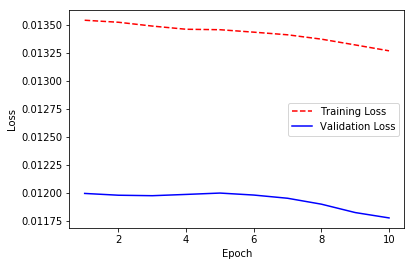

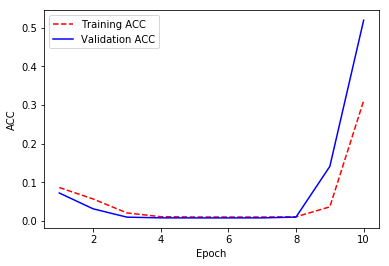

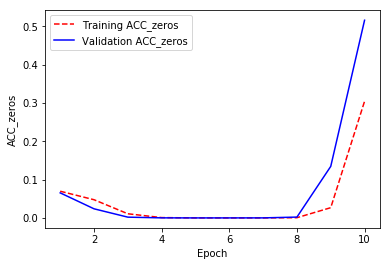

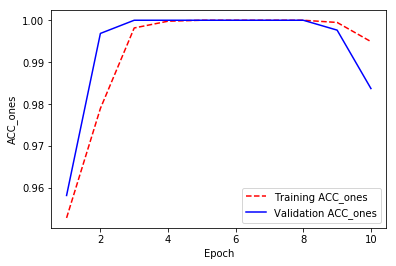

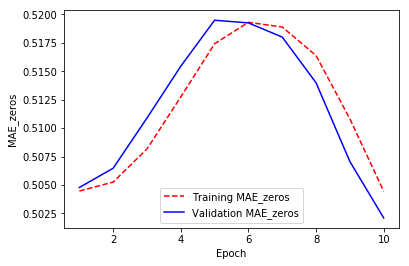

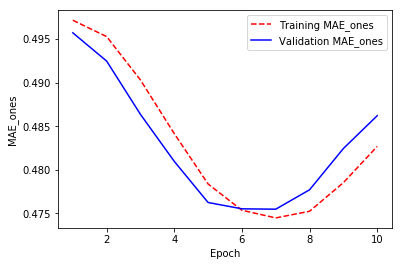

In [14]:
plot(hist.history['loss'], hist.history['val_loss'], "Loss")
plot(hist.history['acc'], hist.history['val_acc'], "ACC")
plot(hist.history['acc_zeros'], hist.history['val_acc_zeros'], "ACC_zeros")
plot(hist.history['acc_ones'], hist.history['val_acc_ones'], "ACC_ones")
plot(hist.history['mae_zeros'], hist.history['val_mae_zeros'], "MAE_zeros")
plot(hist.history['mae_ones'], hist.history['val_mae_ones'], "MAE_ones")

In [ ]:

training_acc = hist.history['acc']
test_acc = hist.history['val_acc']

epoch_count = range(1, len(training_loss) + 1)

plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, test_loss, 'b-')
plt.legend(['Training Loss', 'Validation Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show();

plt.plot(epoch_count, training_acc, 'r--')
plt.plot(epoch_count, test_acc, 'b-')
plt.legend(['Training Acc', 'Validation Acc'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show();

In [ ]:
dir(hist.history)